In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


### Importing Dataset

In [3]:
df=pd.read_csv('Restaurant reviews.csv', encoding = "ISO-8859-1")


In [4]:
df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [5]:
df.shape


(10000, 7)

### Cleaning & Preparing Data

In [6]:
df = df.drop(columns=["Restaurant","Reviewer","Metadata","Time","Pictures"])


In [7]:
y = df["Rating"]
X = df.drop(columns=["Rating"])
X.shape


(10000, 1)

In [8]:
y = y.replace({'Like':3})


In [9]:
y.isnull().sum()


38

In [10]:
y = pd.to_numeric(y)


In [11]:
y = y.fillna(y.median())  


In [12]:
for i in range(0,len(y)):
    y.iloc[i] = round(y.iloc[i],0)


In [13]:
for i in range(0,len(y)):
    if (y[i]>=3):
        y[i] = "Positive"
    else:
        y[i] = "Negative"


In [14]:
# Assuming 'y' is a list of strings representing numbers
for i in range(len(y)):
    try:
        y[i] = int(y[i])  # Convert string to integer
        if y[i] >= 3:
            y[i] = 1
        else:
            y[i] = 0
    except ValueError:
        # Handle non-numeric values here
        # For example, you can skip them or assign a default value
        pass  # Skipping for now


In [15]:
y.unique()


array(['Positive', 'Negative'], dtype=object)

In [16]:
y.shape


(10000,)

-------------------------------------------------------------------------------------------------------------------

# Machine Learning Algorithms

### Applying NLP Processes

In [17]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]',' ', str(X['Review'][i]))
    review = review.lower() #Lowering the words is very imporatant in avoiding classifying same words as different words
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Eleminating words that do not put much value in sentences.
    review = ' '.join(review) #Reconstructing sentences
    corpus.append(review)


### For implementing LSTM goto direct LSTM Section Else Continue


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=9000) #After experimenting with 7500, 5000, 2500 ...9000 worked best.
X = cv.fit_transform(corpus).toarray()


### Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


### Deciding Best Model:
#### Trying Out MultinomialNB

In [20]:
from sklearn.naive_bayes import MultinomialNB
restaurant_review_model = MultinomialNB().fit(X_train, y_train)


In [21]:
y_pred = restaurant_review_model.predict(X_test)


In [22]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)


In [23]:
print(confusion_m)


[[ 457  127]
 [ 102 1814]]


In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.9084


#### Trying out Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=200)

In [31]:
y_pred = randomclassifier.predict(X_test)


In [32]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)


[[ 389  195]
 [  69 1847]]


In [33]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.8944


SVM

In [34]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)


SVC()

In [35]:
y_pred = clf.predict(X_test)


In [36]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)


[[ 366  218]
 [  52 1864]]


In [37]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.892


#### Trying KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2) 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


[[ 315  269]
 [ 227 1689]]
0.8016


### Here, Among Four MultinomialNB has higher accuracy... 

### Applying Bi-Directional LSTM with WordEmbedding

In [39]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


In [40]:
### Vocabulary size
voc_size=5000


In [41]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr


[[4391,
  182,
  994,
  4011,
  182,
  1090,
  1617,
  3314,
  831,
  182,
  1228,
  3337,
  2701,
  644,
  4388,
  103,
  1420,
  2594,
  665,
  3608,
  1850,
  4268,
  3868,
  4831],
 [4391,
  182,
  1932,
  4391,
  1765,
  4059,
  994,
  182,
  182,
  4660,
  3608,
  1850,
  2936,
  1765],
 [3804,
  1580,
  711,
  994,
  711,
  4391,
  652,
  1765,
  1364,
  864,
  561,
  2811,
  2556,
  4680,
  2519,
  4388,
  3839,
  2494,
  864],
 [3608,
  1850,
  2749,
  711,
  2546,
  4889,
  2870,
  182,
  994,
  221,
  1120,
  2633,
  3609,
  1228],
 [994,
  182,
  4009,
  988,
  1398,
  1827,
  4883,
  1991,
  182,
  4345,
  1364,
  4589,
  2066,
  183,
  4391,
  4388,
  182],
 [3030,
  182,
  1765,
  182,
  994,
  77,
  2633,
  1079,
  1765,
  994,
  182,
  3305,
  182,
  3215,
  1911,
  4595,
  182,
  2184,
  543],
 [1944,
  1228,
  4391,
  3799,
  994,
  4009,
  1587,
  1765,
  4388,
  302,
  1824,
  3609,
  525,
  2066,
  4268,
  3804,
  3609,
  1228],
 [2066,
  1318,
  3594,
  3053,
  3

In [42]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)


[[   0    0    0 ... 4268 3868 4831]
 [   0    0    0 ... 1850 2936 1765]
 [   0    0    0 ... 3839 2494  864]
 ...
 [2641 3343 4511 ... 1208 4569  973]
 [   0    0  561 ... 1386 1765 4254]
 [4841 4967 2806 ...  138 1542 4391]]


In [43]:
embedded_docs[0]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 4391,  182,  994, 4011,  182, 1090,
       1617, 3314,  831,  182, 1228, 3337, 2701,  644, 4388,  103, 1420,
       2594,  665, 3608, 1850, 4268, 3868, 4831])

In [44]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)


In [45]:
X_final.shape,y_final.shape


((10000, 40), (10000,))

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=0)


In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout

## Creating model
embedding_vector_features = 40
model = tf.keras.Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [48]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Check data types and shapes of input features
print("X_train data type:", type(X_train))
print("X_train shape:", X_train.shape)
print("X_test data type:", type(X_test))
print("X_test shape:", X_test.shape)

# Check data types and shapes of target labels
print("y_train data type:", type(y_train))
print("y_train shape:", y_train.shape)
print("y_test data type:", type(y_test))
print("y_test shape:", y_test.shape)


X_train data type: <class 'numpy.ndarray'>
X_train shape: (7500, 40)
X_test data type: <class 'numpy.ndarray'>
X_test shape: (2500, 40)
y_train data type: <class 'numpy.ndarray'>
y_train shape: (7500,)
y_test data type: <class 'numpy.ndarray'>
y_test shape: (2500,)


In [49]:
# Check unique values in y_train and y_test
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))


Unique values in y_train: ['Negative' 'Positive']
Unique values in y_test: ['Negative' 'Positive']


In [50]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform on y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform y_test
y_test_encoded = label_encoder.transform(y_test)

# Check the encoded labels
print("Encoded labels for y_train:", y_train_encoded)
print("Encoded labels for y_test:", y_test_encoded)

# Check the mapping of labels
print("Mapping of labels:", label_encoder.classes_)


Encoded labels for y_train: [1 1 1 ... 0 1 1]
Encoded labels for y_test: [0 1 0 ... 1 1 0]
Mapping of labels: ['Negative' 'Positive']


In [51]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)


Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\iamim\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\iamim\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\iamim\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\iamim\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\iamim\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\iamim\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\iamim\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\iamim\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\iamim\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\iamim\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\iamim\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\iamim\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\iamim\AppData\Local\Temp\ipykernel_1860\1249521484.py", line 1, in <module>

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\iamim\anaconda3\Lib\site-packages\keras\src\losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_5897]

In [52]:
y_pred=model.predict_classes(X_test)


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)


array([[ 315,  269],
       [ 227, 1689]], dtype=int64)

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)


0.8016

-----------------------------------------------------------------------

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(40,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=5, batch_size=64)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc)


Epoch 1/5


118/118 [==============================] - 2s 6ms/step - loss: 94.3338 - accuracy: 0.6345 - val_loss: 36.9568 - val_accuracy: 0.6020
Epoch 2/5
118/118 [==============================] - 0s 1ms/step - loss: 27.9198 - accuracy: 0.6487 - val_loss: 21.8090 - val_accuracy: 0.6636
Epoch 3/5
118/118 [==============================] - 0s 1ms/step - loss: 18.6510 - accuracy: 0.6609 - val_loss: 16.9565 - val_accuracy: 0.6888
Epoch 4/5
118/118 [==============================] - 0s 2ms/step - loss: 13.4541 - accuracy: 0.6612 - val_loss: 16.7119 - val_accuracy: 0.7396
Epoch 5/5
79/79 [==============================] - 0s 956us/step - loss: 12.4736 - accuracy: 0.4876
Test accuracy: 0.4875999987125397


### Still MultinomialNB has higher Accuracy

--------------------------------------------------------------------------------------------------------------------------

## Another appraoch for this ML models

### LR

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [57]:
logistic_model = LogisticRegression()


In [58]:
logistic_model.fit(X_train, y_train)


LogisticRegression()

In [59]:
# Evaluate the model
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.766
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       584
    Positive       0.77      1.00      0.87      1916

    accuracy                           0.77      2500
   macro avg       0.38      0.50      0.43      2500
weighted avg       0.59      0.77      0.66      2500



XGBoost

In [60]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


In [61]:
# Define the XGBoost model
model = xgb.XGBClassifier()


In [62]:
from sklearn.metrics import classification_report

# Train the model
model.fit(X_train, y_train_encoded)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Decode labels
y_pred_train_decoded = label_encoder.inverse_transform(y_pred_train)
y_pred_test_decoded = label_encoder.inverse_transform(y_pred_test)

# Evaluate the model
train_accuracy = (y_pred_train_decoded == y_train).mean()
test_accuracy = (y_pred_test_decoded == y_test).mean()

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Classification report
print("\nClassification Report on Train Data:")
print(classification_report(y_train, y_pred_train_decoded))

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred_test_decoded))


Train Accuracy: 0.9750666666666666
Test Accuracy: 0.7844

Classification Report on Train Data:
              precision    recall  f1-score   support

    Negative       0.99      0.91      0.95      1863
    Positive       0.97      1.00      0.98      5637

    accuracy                           0.98      7500
   macro avg       0.98      0.95      0.97      7500
weighted avg       0.98      0.98      0.97      7500


Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative       0.58      0.27      0.37       584
    Positive       0.81      0.94      0.87      1916

    accuracy                           0.78      2500
   macro avg       0.70      0.61      0.62      2500
weighted avg       0.76      0.78      0.75      2500



Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Naive Bayes classifier
naive_bayes_classifier = GaussianNB()

# Train the classifier
naive_bayes_classifier.fit(X_train, y_train_encoded)

# Predictions on training and test data
y_pred_train = naive_bayes_classifier.predict(X_train)
y_pred_test = naive_bayes_classifier.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
test_accuracy = accuracy_score(y_test_encoded, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Classification report
print("\nClassification Report on Train Data:")
print(classification_report(y_train_encoded, y_pred_train, target_names=label_encoder.classes_))

print("\nClassification Report on Test Data:")
print(classification_report(y_test_encoded, y_pred_test, target_names=label_encoder.classes_))


Train Accuracy: 0.7444
Test Accuracy: 0.748

Classification Report on Train Data:
              precision    recall  f1-score   support

    Negative       0.45      0.15      0.22      1863
    Positive       0.77      0.94      0.85      5637

    accuracy                           0.74      7500
   macro avg       0.61      0.54      0.53      7500
weighted avg       0.69      0.74      0.69      7500


Classification Report on Test Data:
              precision    recall  f1-score   support

    Negative       0.39      0.14      0.21       584
    Positive       0.78      0.93      0.85      1916

    accuracy                           0.75      2500
   macro avg       0.59      0.54      0.53      2500
weighted avg       0.69      0.75      0.70      2500



### Model Evaluation

In [66]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (7500, 9000)
Shape of X_test: (2500, 9000)


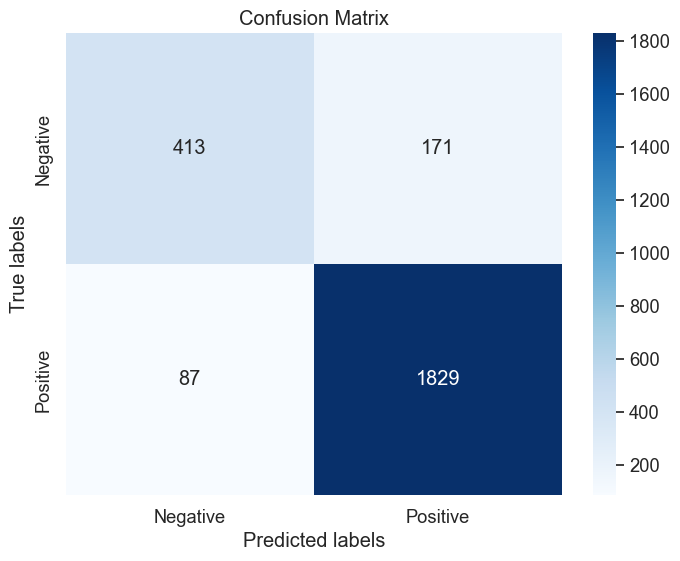

In [68]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to your target variable and transform it
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now, initialize and train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train_encoded)

# Now make predictions on the test set
predicted_labels = model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, predicted_labels)

# Define classes (assuming binary classification)
classes = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


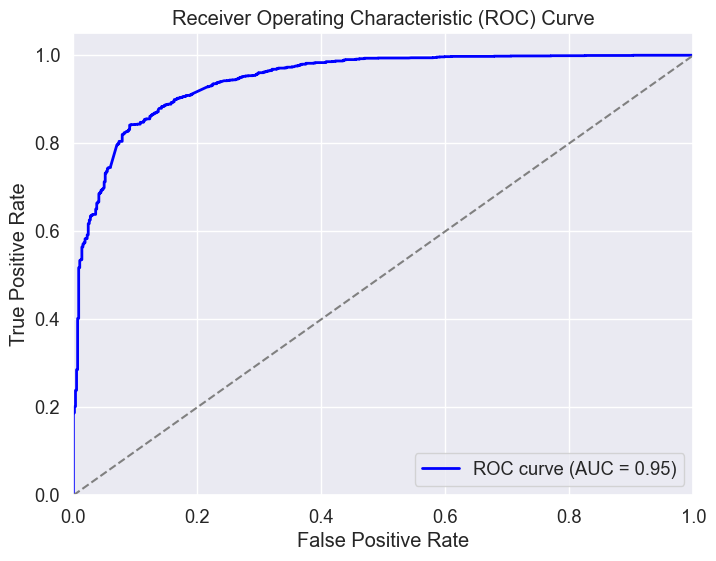

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob)

# Calculate AUC
auc_value = roc_auc_score(y_test_encoded, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label='ROC curve (AUC = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
